# Aim

Create both atmospheric turbulence and vibrations at once!

In [1]:
# imports and setup

# I have hcipy as a submodule, so this import may vary
import sys
sys.path.append("..")
from hcipy.hcipy import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats, signal, optimize

from aberrations import *

In [2]:
tt_cms = make_atm_data()

Text(0.5, 1.0, 'Atmospheric tip-tilts')

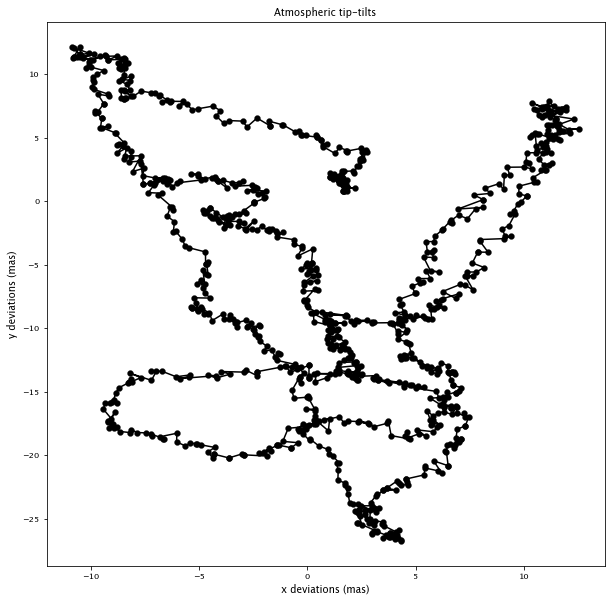

In [3]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms[:,0], tt_cms[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts")

In [10]:
vibe_aberrations = make_2D_vibe_data()
combined = make_noisy_data(tt_cms + vibe_aberrations, 0)

Text(0.5, 1.0, 'Vibration tip-tilts')

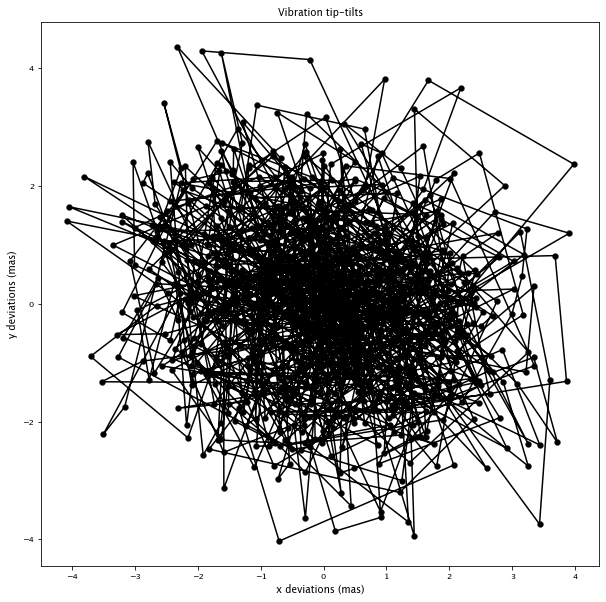

In [11]:
plt.figure(figsize=(10,10))
plt.plot(vibe_aberrations[:,0], vibe_aberrations[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Vibration tip-tilts")

Text(0.5, 1.0, 'Full tip-tilts')

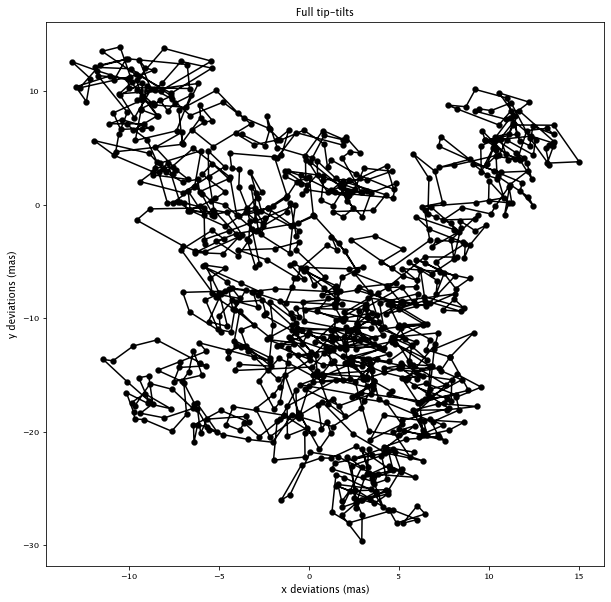

In [12]:
plt.figure(figsize=(10,10))
plt.plot(combined[:,0], combined[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Full tip-tilts")

combined m = -1.7161312499398298


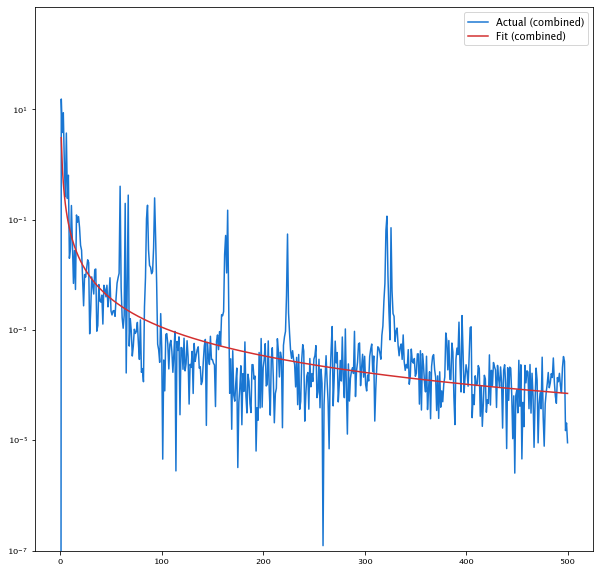

In [13]:
# plotting the PSD of just one dimension, expecting an f^-2 power law
plt.figure(figsize=(10,10))
freqs, psd = signal.periodogram(tt_cms[:,0], f_sampling)
log_freqs, log_power = np.log(freqs[1:]), np.log(psd[1:])
m, b, _, _, _ = stats.linregress(log_freqs, log_power)

def plot_powerlaw(aberration, description):
    freqs, psd = signal.periodogram(aberration, f_sampling)
    log_freqs, log_power = np.log(freqs[1:]), np.log(psd[1:])
    m, b = stats.linregress(log_freqs, log_power)[:2]
    print(description + " m =", m)
    plt.semilogy(freqs, psd, label='Actual (' + description + ')')
    plt.semilogy(freqs[1:], np.exp(b) * freqs[1:]**m, label='Fit (' + description + ')')
    plt.ylim(1e-7)
    plt.legend()
    
#plot_powerlaw(tt_cms[:,0], "turbulence")
plot_powerlaw(combined[:,0], "combined")

In [14]:
vibe_only_

NameError: name 'vibe_only_' is not defined